# Forecasting Notebook

#### Using Adam's wrangle and clustering code to prep the data:

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

# time series imports
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
from datetime import datetime

# pickle for reloading model object
import pickle

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
# sns.set_palette('tab20')
sns.set_theme(style="whitegrid")

# custom modules
import wrangle as w
import explore as e

In [2]:
# Clustering
# load model
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

KMeans(n_clusters=7, random_state=527)

In [3]:
# acquire and prep data
df = w.get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = w.create_df_dict(df)
# charaterize series of data for each industry to make time series data into continuous data we can cluster on
char_df = e.create_char_df(industry_df_dict, ind_list)
# scale these characterizations for clustering
scaled_char_df = e.scale(char_df, MinMaxScaler())
# cluster and plot results
# char_df = e.load_cluster_and_plot_no_legend(loaded_model, scaled_char_df, char_df, df)

In [4]:
def get_tx_data():
    '''
    Reads in raw data, filters, melts some columns to rows to get monthly observations, and creates datetime index
    '''
    df = pd.read_excel('QCEW-TX-L3-2016.xlsx') # get raw data
    # df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
    df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
    df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
    df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
    df['Date'] = df.apply(w.extract_date, axis=1) # use function to pull out date from multiple columns
    df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
    return df

In [5]:
def create_df_dict(df):
    '''
    Takes in df and creates a dictionary of series for all industries and the time interval we are interested in
    '''
    ind_list = df.Industry.value_counts().index.tolist() # get list of industries
    ind_list.remove('Monetary Authorities-Central Bank') # remove this industry since it has missing data
    ind_list.remove('Unclassified') # remove this industry since it is a catchall for a lot of unique industries that would be noise for our clustering
    industry_df_dict = {} # create empty df for dfs for each industry
    for ind in ind_list:
        industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index() # pull out series
    return industry_df_dict, ind_list

In [6]:
# get dictionary with all industries
# get all monthly data
df = get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = create_df_dict(df)

In [7]:
forecast_ind_list = [
    'Performing Arts, Spectator Sports, and Related Industries',
    'Miscellaneous Store Retailers ',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ',
    'Accommodation',
    'Food Services and Drinking Places',
    'Motion Picture and Sound Recording Industries',
    'Personal and Laundry Services',
    'Furniture and Home Furnishings Stores ',
    'Leather and Allied Product Manufacturing',
    'Amusement, Gambling, and Recreation Industries',
    'Scenic and Sightseeing Transportation',
    'Clothing and Clothing Accessories Stores '
]

In [8]:
forecast_ind_dict = {}
for ind in forecast_ind_list:
    forecast_ind_dict[ind] = industry_df_dict[ind]

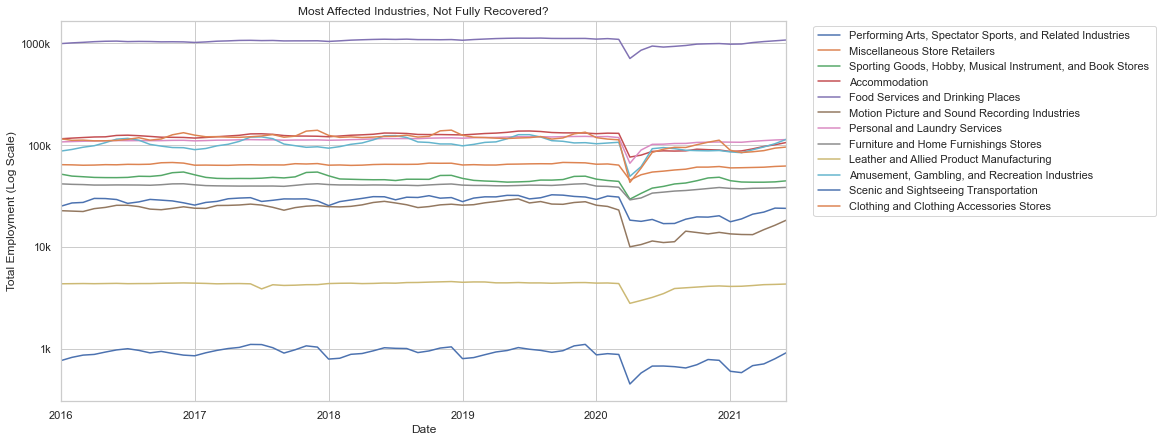

In [9]:
for ind in forecast_ind_list:
    forecast_ind_dict[ind].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Most Affected Industries, Not Fully Recovered?')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));
plt.show()

In [15]:
food = forecast_ind_dict['Food Services and Drinking Places']
movie = forecast_ind_dict['Motion Picture and Sound Recording Industries']

In [11]:
len(food)

66

In [12]:
food['2020':'2021']

Date
2020-01-01    1101764
2020-02-01    1114748
2020-03-01    1095979
2020-04-01     710703
2020-05-01     857109
2020-06-01     941960
2020-07-01     920388
2020-08-01     935779
2020-09-01     953958
2020-10-01     984009
2020-11-01     991496
2020-12-01     996723
2021-01-01     982489
2021-02-01     986414
2021-03-01    1019267
2021-04-01    1042490
2021-05-01    1060544
2021-06-01    1080196
Name: Total Employment, dtype: int64

<AxesSubplot:xlabel='Date'>

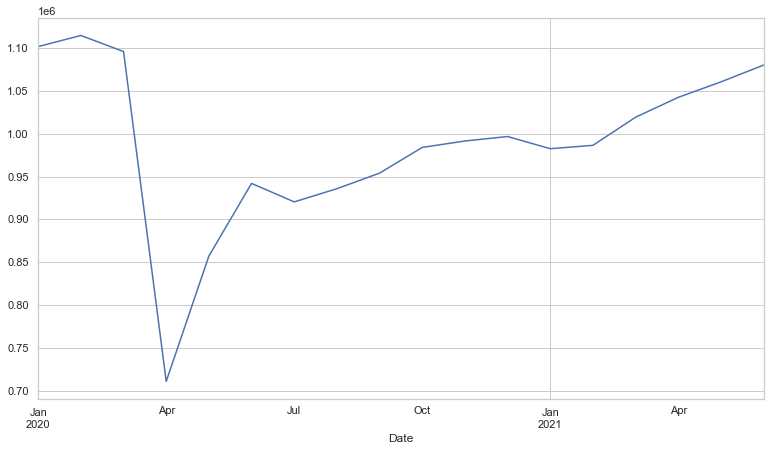

In [13]:
food['2020':'2021'].plot()

<AxesSubplot:xlabel='Date'>

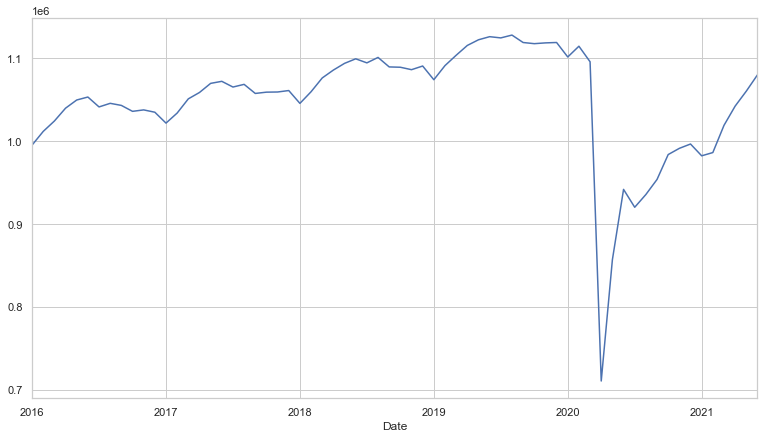

In [14]:
food.plot()

<AxesSubplot:xlabel='Date'>

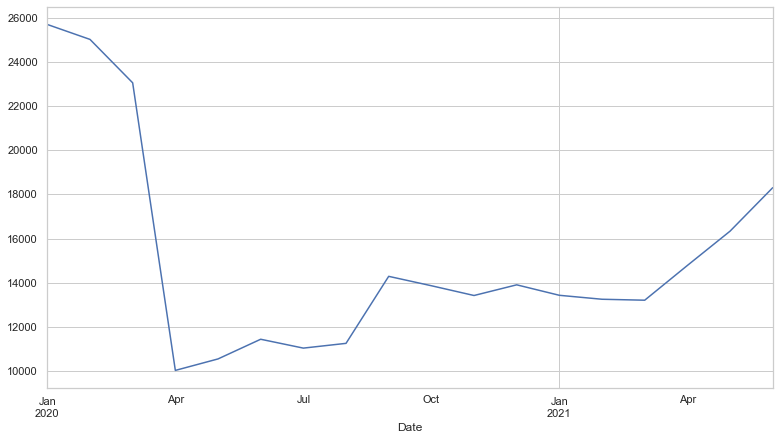

In [18]:
movie['2020':'2021'].plot()